<a href="https://colab.research.google.com/github/GadirajuSanjayvarma/EVA4/blob/master/S6/EVA4_S6_FILE1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#importing all the modules for model

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
%matplotlib inline
import matplotlib.pyplot as plt


In [0]:
#defining transformations for both training and testing data
train_transforms=transforms.Compose(
    [
     #rotates an image by above mentioned degree and filling the left porions with white
     transforms.RandomRotation(degrees=(-15.0,+15.0),fill=(1,)),
     #converting an pil image to tensor by scaling b/w 0 and 1
     transforms.ToTensor(),
     #normalizing an image using mean and standard deviation
     transforms.Normalize((0.1307,),(0.3801,))
    ])
test_transforms=transforms.Compose(
    [
     #converting an pil image to tensor by scaling b/w 0 and 1
     transforms.ToTensor(),
     #normalizing an image using mean and standard deviation
     transforms.Normalize((0.1307,),(0.3801,))
    ])



In [0]:
#creating datasets for both train and test sets seperately
train=datasets.MNIST("/data",train=True,transform=train_transforms,download=True)
test=datasets.MNIST("/data",train=False,download=True,transform=test_transforms)

In [0]:
#setting seed
SEED=1
#checking if cuda ia availble or not
cuda=torch.cuda.is_available()
print(cuda)
if cuda:
  torch.cuda.manual_seed(SEED)
else:
  torch.manual_seed(SEED)
#num_workers are useful in efficiently managing the no of processes done by cpu core
#if num of workers are more then more amount of memory is allocated to the work
#when we set the pin_memory to true it is going to transfer our files from cpu to gpu during training
dataloader_args=dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else  dict(shuffle=True,batch_size=128)
train_loader=torch.utils.data.DataLoader(train,**dataloader_args)
test_loader=torch.utils.data.DataLoader(test,**dataloader_args)

True


<class 'numpy.ndarray'>
torch.Size([28, 28])


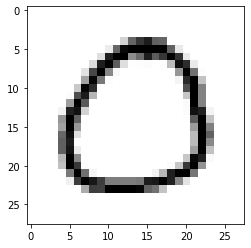

In [0]:
#iter function is helping us to iterate over images and labels
dataiter=iter(train_loader)
#seperating images and labels
images,labels=dataiter.next()
print(type(images[0].numpy()))
plt.imshow(images[0].squeeze().numpy(),cmap='gray_r',interpolation='nearest')
print(images[0].squeeze().size())



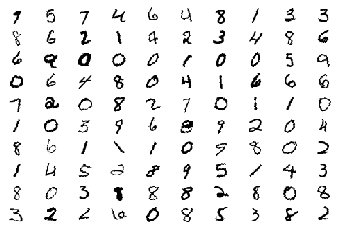

In [0]:
#it is very useful for clearning and mentioning images(plt,figure())
figure=plt.figure()
#displaying 100 images of plot 10,10
for i in range(100):
  plt.subplot(10,10,i+1,)
  plt.axis(False)
  plt.imshow(images[i].numpy().squeeze(),cmap='gray_r')
#we can remove image using plt.close() function
plt.close()
#in the similar way we are printing another set of images
figure=plt.figure()
for i in  range(100):
  plt.subplot(10,10,i+1,)
  plt.axis(False)
  plt.imshow(images[i].numpy().squeeze(),cmap='gray_r') 


In [0]:
dropout_value = 0.04
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Convolution Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # input_side = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10, RF = 14
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8, RF = 18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6, RF = 22

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF = 26

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
#checking whether cuda is available or not based on gpu condition
#if cuda is available then device will be cuda else cpu
cuda=torch.cuda.is_available()
print(cuda)
device="cuda" if cuda else "cpu"
#we are sending model to summary function
model=Net().to(device)
summary(model,input_size=(1,28,28))

True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

**Model training without L1 and L2 regularization**

In [0]:
#for having cooler graphics we can have tqdm installed
from tqdm import tqdm
#we are initialising lists to contain loss and accuracy values to plot some graph
test_losses=[]
test_accuracy=[]
images_array=[]
predicted_value=[]
actual_value=[]
count_images=0
def train(model,device,scheduler,train_loader,epoch,optimizer):
  #we are calling model.train() so that our model prepares itself in training mode and all other things like batch normalisationa nd dropout behaves accordingly.
  model.train()
  #so tqdm() just acts on a iterator and it will jsut  gives representations in form of progressbar.
  pbar=tqdm(train_loader)
  #variables which contain correct values and processed values which helps in finding accuracy and loss
  correct=0
  processed=0
  for batch_idx,(data,target) in enumerate(pbar):
    #sending data and target samples to device which is gpu
    data,target=data.to(device),target.to(device)
    #we are setting our gradients to zero which is very useful
    optimizer.zero_grad()
    #predicting the output
    y_pred=model(data)#print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
    #calculating the loss
    loss=F.nll_loss(y_pred,target)
    #updating loss and taking a step by optimizer
    loss.backward()
    optimizer.step()
    #updating tqdm and pbar
    #here y_pred will be equal to no of channels in our output
    #actually we need that for backpropagation
    #now we will find highest value which will be our prediction
    #so we will use argmax to fing max value for each image output
    #correct will be no of images correctly processes in batch.we will compare pred value to target.if it is equal it will add one value to correct
    pred=y_pred.argmax(dim=1,keepdim=True)
    processed+=len(data)
    #.sum() will count no of trues in prediction for each batch and .item() will convert our tensor output to scalar output
    correct+=pred.eq(target.view_as(pred)).sum().item()
    #we are appending losses into train_accuracy and we are also appending accuracy at end of each epoch
    pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    scheduler.step()

def test(model,device,test_loader):
  global count_images
  loss=0
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data,target in (test_loader):
      data,target=data.to(device),target.to(device)
      output=model(data)
      test_loss+=F.nll_loss(output,target,reduction='sum').item()
      predicted=output.argmax(dim=1,keepdim=True)
      #print(len(predicted))
      if(count_images<=26):
          for j in range(len(predicted)):
              if(predicted[j]!=target[j]):
                  images_array.append(data[j])
                  predicted_value.append(predicted[j].item())
                  actual_value.append(target[j].item())
                  count_images+=1

      correct+=predicted.eq(target.view_as(predicted)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy.append(100. * correct / len(test_loader.dataset))
    


In [0]:
#importing optimizing step lr and cycle lr from torch.optim.lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
device="cuda" if cuda else "cpu"
model=Net().to(device)
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
#scheduler=StepLR(optimizer,gamma=0.5,step_size=5)
scheduler=OneCycleLR(optimizer,max_lr=0.1,steps_per_epoch=len(train_loader),epochs=40)
EPOCHS=40
for epoch in range(EPOCHS):
  print('epochs',epoch)
  train(model,device,scheduler,train_loader,epoch,optimizer) 
  print(scheduler.get_lr())
  test(model,device,test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

epochs 0


Loss=0.13010968267917633 Batch_id=468 Accuracy=75.58: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]

[0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1190, Accuracy: 9684/10000 (96.84%)

epochs 1


Loss=0.11723044514656067 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]


[0.010433014025713727]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9852/10000 (98.52%)

epochs 2


Loss=0.09976458549499512 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]

[0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9828/10000 (98.28%)

epochs 3


Loss=0.1212669387459755 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]

[0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9891/10000 (98.91%)

epochs 4


Loss=0.024371981620788574 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]

[0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9808/10000 (98.08%)

epochs 5


Loss=0.04526326060295105 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]

[0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Accuracy: 9884/10000 (98.84%)

epochs 6


Loss=0.02313711680471897 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]

[0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9919/10000 (99.19%)

epochs 7


Loss=0.031110132113099098 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]

[0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9901/10000 (99.01%)

epochs 8


Loss=0.08803173154592514 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:15<00:00, 30.49it/s]

[0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

epochs 9


Loss=0.07607302814722061 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]

[0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9937/10000 (99.37%)

epochs 10


Loss=0.01569087617099285 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]

[0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9916/10000 (99.16%)

epochs 11


Loss=0.05606856942176819 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 29.29it/s]


[0.09999999856920878]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

epochs 12


Loss=0.009212985634803772 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:15<00:00, 29.90it/s]

[0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

epochs 13


Loss=0.004811366554349661 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:15<00:00, 30.23it/s]


[0.09874373753452848]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9943/10000 (99.43%)

epochs 14


Loss=0.06771165877580643 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]


[0.09719022574054306]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9940/10000 (99.40%)

epochs 15


Loss=0.017132515087723732 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]

[0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

epochs 16


Loss=0.026502901688218117 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]

[0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

epochs 17


Loss=0.005482728127390146 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


[0.08908415873743396]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

epochs 18


Loss=0.11325465887784958 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]


[0.08534693853699324]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

epochs 19


Loss=0.0599910169839859 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]


[0.08116521259079444]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

epochs 20


Loss=0.03702826797962189 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]


[0.0765915685289049]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

epochs 21


Loss=0.005909234285354614 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]

[0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9950/10000 (99.50%)

epochs 22


Loss=0.007895986549556255 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:15<00:00, 29.42it/s]

[0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9951/10000 (99.51%)

epochs 23


Loss=0.010869279503822327 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]

[0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9947/10000 (99.47%)

epochs 24


Loss=0.007233381271362305 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]


[0.055586514919216574]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0158, Accuracy: 9944/10000 (99.44%)

epochs 25


Loss=0.011795456521213055 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]

[0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0150, Accuracy: 9956/10000 (99.56%)

epochs 26


Loss=0.00220874953083694 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]


[0.04439011241507181]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 9955/10000 (99.55%)

epochs 27


Loss=0.08317295461893082 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]


[0.03886253648110994]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

epochs 28


Loss=0.02221669815480709 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 29.48it/s]

[0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0143, Accuracy: 9957/10000 (99.57%)

epochs 29


Loss=0.009320328943431377 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]


[0.028295323462426913]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0149, Accuracy: 9953/10000 (99.53%)

epochs 30


Loss=0.05282716825604439 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]

[0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 9954/10000 (99.54%)

epochs 31


Loss=0.058029454201459885 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]

[0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 9961/10000 (99.61%)

epochs 32


Loss=0.032256241887807846 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]

[0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9954/10000 (99.54%)

epochs 33


Loss=0.0010704994201660156 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:15<00:00, 30.25it/s]

[0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 9960/10000 (99.60%)

epochs 34


Loss=0.005962590221315622 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]

[0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 9957/10000 (99.57%)

epochs 35


Loss=0.012454484589397907 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]

[0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 9956/10000 (99.56%)

epochs 36


Loss=0.11216547340154648 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]

[0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 9953/10000 (99.53%)

epochs 37


Loss=0.003266741754487157 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]

[0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 9957/10000 (99.57%)

epochs 38


Loss=0.04958390071988106 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]

[0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0126, Accuracy: 9958/10000 (99.58%)

epochs 39


Loss=0.011834472417831421 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]

[4.0143079121884904e-07]



Test set: Average loss: 0.0130, Accuracy: 9958/10000 (99.58%)



**25 Misclassified Images obtained without L1 and L2 regularization in model**

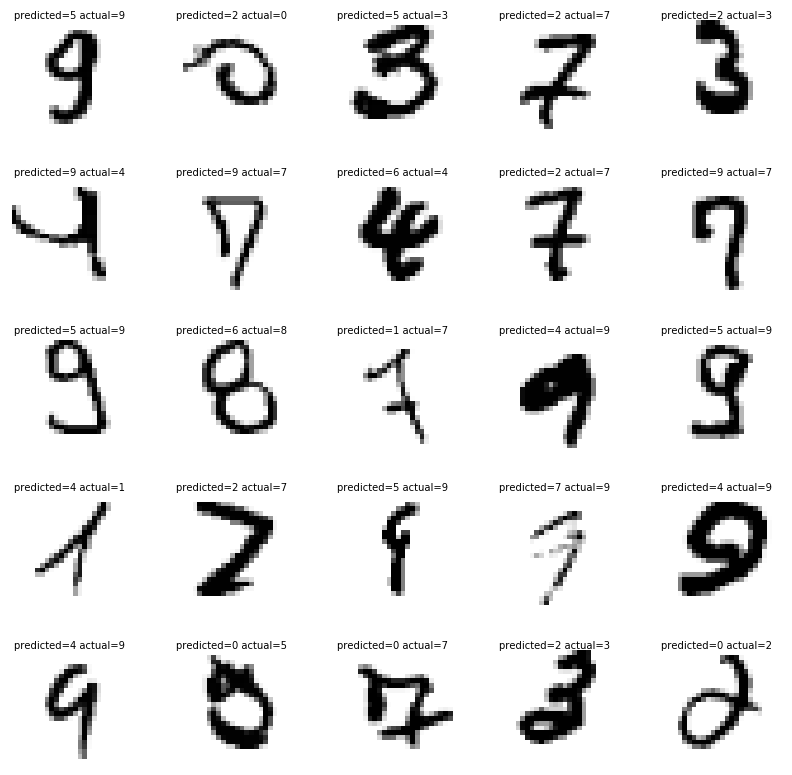

In [0]:
figure=plt.figure(figsize=(14,14))
#displaying 100 images of plot 10,10
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis(False)
  plt.imshow(images_array[i].cpu().numpy().squeeze(),cmap='gray_r')
  s="predicted="+str(predicted_value[i])+" actual="+str(actual_value[i])
  plt.text(1,2,s)

Model training and testing using L2 regularization

In [0]:
#for having cooler graphics we can have tqdm installed
from tqdm import tqdm
#we are initialising lists to contain loss and accuracy values to plot some graphs
test_losses1=[]
test_accuracy1=[]
images_array1=[]
predicted_value1=[]
actual_value1=[]
count_images=0
def train1(model,device,scheduler,train_loader,epoch,optimizer):
  #we are calling model.train() so that our model prepares itself in training mode and all other things like batch normalisationa nd dropout behaves accordingly.
  model.train()
  #so tqdm() just acts on a iterator and it will jsut  gives representations in form of progressbar.
  pbar=tqdm(train_loader)
  #variables which contain correct values and processed values which helps in finding accuracy and loss
  correct=0
  processed=0
  for batch_idx,(data,target) in enumerate(pbar):
    #sending data and target samples to device which is gpu
    data,target=data.to(device),target.to(device)
    #we are setting our gradients to zero which is very useful
    optimizer.zero_grad()
    #predicting the output
    y_pred=model(data)#print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
    #calculating the loss
    loss=F.nll_loss(y_pred,target)
    #appending the losses to train_losses array for plotting graph
    #updating loss and taking a step by optimizer
    loss.backward()
    optimizer.step()
    #updating tqdm and pbar
    #here y_pred will be equal to no of channels in our output
    #actually we need that for backpropagation
    #now we will find highest value which will be our prediction
    #so we will use argmax to fing max value for each image output
    #correct will be no of images correctly processes in batch.we will compare pred value to target.if it is equal it will add one value to correct
    pred=y_pred.argmax(dim=1,keepdim=True)
    processed+=len(data)
    #.sum() will count no of trues in prediction for each batch and .item() will convert our tensor output to scalar output
    correct+=pred.eq(target.view_as(pred)).sum().item()
    #we are appending losses into train_accuracy and we are also appending accuracy at end of each epoch
    pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_accuracy.append(100*correct/processed)
    scheduler.step()
  #train_end_epoch.append(train_accuracy[-1])
  
def test1(model,device,test_loader):
  global count_images
  loss=0
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data,target in (test_loader):
      data,target=data.to(device),target.to(device)
      output=model(data)
      test_loss+=F.nll_loss(output,target,reduction='sum').item()
      predicted=output.argmax(dim=1,keepdim=True)
      #print(len(predicted))
      if(count_images<=26):
          for j in range(len(predicted)):
              if(predicted[j]!=target[j]):
                  #print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
                  images_array1.append(data[j])
                  predicted_value1.append(predicted[j].item())
                  actual_value1.append(target[j].item())
                  #figure=plt.figure()
                  #plt.imshow(data[j].cpu().squeeze(),cmap='gray_r')
                  #plt.show()
                  count_images+=1

      correct+=predicted.eq(target.view_as(predicted)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses1.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy1.append(100. * correct / len(test_loader.dataset))
    


In [0]:
#importing optimizing step lr and cycle lr from torch.optim.lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
device="cuda" if cuda else "cpu"
model=Net().to(device)
optimizer1=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
#scheduler=StepLR(optimizer,gamma=0.5,step_size=5)
scheduler=OneCycleLR(optimizer1,max_lr=0.1,steps_per_epoch=len(train_loader),epochs=40)
EPOCHS=40
for epoch in range(EPOCHS):
  print('epochs',epoch)
  train1(model,device,scheduler,train_loader,epoch,optimizer1) 
  print(scheduler.get_lr())
  test1(model,device,test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

epochs 0


Loss=0.07634999603033066 Batch_id=468 Accuracy=79.74: 100%|██████████| 469/469 [00:15<00:00, 30.58it/s]

[0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1223, Accuracy: 9672/10000 (96.72%)

epochs 1


Loss=0.04034760594367981 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]

[0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9858/10000 (98.58%)

epochs 2


Loss=0.11874759942293167 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:15<00:00, 30.37it/s]

[0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0535, Accuracy: 9851/10000 (98.51%)

epochs 3


Loss=0.06576450914144516 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]

[0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9890/10000 (98.90%)

epochs 4


Loss=0.03030504286289215 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]

[0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9866/10000 (98.66%)

epochs 5


Loss=0.01983300782740116 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]

[0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9866/10000 (98.66%)

epochs 6


Loss=0.06825674325227737 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]

[0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9897/10000 (98.97%)

epochs 7


Loss=0.09990521520376205 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]

[0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9914/10000 (99.14%)

epochs 8


Loss=0.1001240536570549 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:15<00:00, 36.68it/s]

[0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9886/10000 (98.86%)

epochs 9


Loss=0.16568265855312347 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]

[0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0375, Accuracy: 9871/10000 (98.71%)

epochs 10


Loss=0.1472439169883728 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:15<00:00, 30.61it/s]

[0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9903/10000 (99.03%)

epochs 11


Loss=0.10104290395975113 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]

[0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9896/10000 (98.96%)

epochs 12


Loss=0.08740247040987015 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]


[0.09968427106235794]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9915/10000 (99.15%)

epochs 13


Loss=0.028843307867646217 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 31.04it/s]

[0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9908/10000 (99.08%)

epochs 14


Loss=0.025357654318213463 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]

[0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9893/10000 (98.93%)

epochs 15


Loss=0.10585219413042068 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]

[0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9908/10000 (99.08%)

epochs 16


Loss=0.051820944994688034 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 31.28it/s]

[0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9872/10000 (98.72%)

epochs 17


Loss=0.09196416288614273 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]

[0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)

epochs 18


Loss=0.02329838275909424 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]


[0.08534693853699324]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9897/10000 (98.97%)

epochs 19


Loss=0.028620049357414246 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]

[0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9905/10000 (99.05%)

epochs 20


Loss=0.15768001973628998 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:15<00:00, 30.98it/s]


[0.0765915685289049]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9878/10000 (98.78%)

epochs 21


Loss=0.008409306406974792 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


[0.07168352257909298]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

epochs 22


Loss=0.09479689598083496 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]

[0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9918/10000 (99.18%)

epochs 23


Loss=0.04936257004737854 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]

[0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0415, Accuracy: 9877/10000 (98.77%)

epochs 24


Loss=0.06254436075687408 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:15<00:00, 31.18it/s]

[0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9895/10000 (98.95%)

epochs 25


Loss=0.08667171001434326 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 30.73it/s]

[0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9883/10000 (98.83%)

epochs 26


Loss=0.036328334361314774 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]

[0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

epochs 27


Loss=0.06009532883763313 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 37.66it/s]

[0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9926/10000 (99.26%)

epochs 28


Loss=0.05269867181777954 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.75it/s]

[0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

epochs 29


Loss=0.031204378232359886 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]

[0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

epochs 30


Loss=0.06848534196615219 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]

[0.023388575212655503]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9947/10000 (99.47%)

epochs 31


Loss=0.0611935593187809 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:15<00:00, 30.92it/s]


[0.018816483585009303]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9935/10000 (99.35%)

epochs 32


Loss=0.0396924763917923 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]

[0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

epochs 33


Loss=0.04022175446152687 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]


[0.010901325460499198]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)

epochs 34


Loss=0.024909330531954765 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]


[0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9950/10000 (99.50%)

epochs 35


Loss=0.04177125170826912 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]

[0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9945/10000 (99.45%)

epochs 36


Loss=0.017896374687552452 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:15<00:00, 30.77it/s]


[0.0028022729640383836]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)

epochs 37


Loss=0.006159260869026184 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]

[0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9958/10000 (99.58%)

epochs 38


Loss=0.016198575496673584 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]


[0.00031345040150706035]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9946/10000 (99.46%)

epochs 39


Loss=0.04171761870384216 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 30.57it/s]


[4.0143079121884904e-07]

Test set: Average loss: 0.0149, Accuracy: 9952/10000 (99.52%)



25 Misclassified images in using  L2 regularization in the model

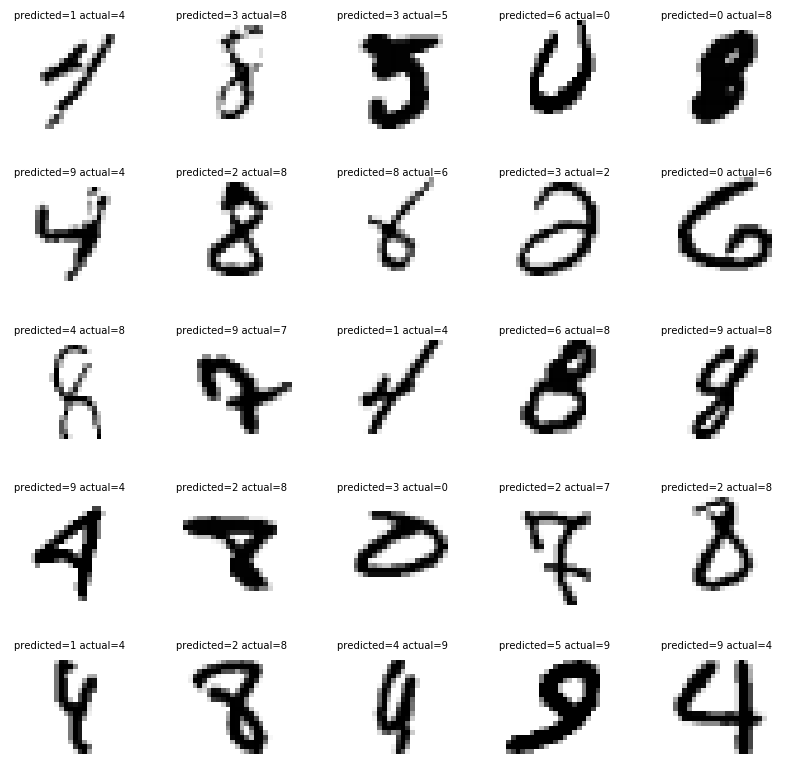

In [0]:
figure=plt.figure(figsize=(14,14))
#displaying 100 images of plot 10,10
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis(False)
  plt.imshow(images_array1[i].cpu().numpy().squeeze(),cmap='gray_r')
  s="predicted="+str(predicted_value1[i])+" actual="+str(actual_value1[i])
  plt.text(1,2,s)

**Model and Training using L1 regularization**

In [0]:
#for having cooler graphics we can have tqdm installed
from tqdm import tqdm
#we are initialising lists to contain loss and accuracy values to plot some graphs
test_losses2=[]
test_accuracy2=[]
images_array2=[]
predicted_value2=[]
actual_value2=[]
count_images=0
def train2(model,device,scheduler,train_loader,epoch,optimizer):
  #we are calling model.train() so that our model prepares itself in training mode and all other things like batch normalisationa nd dropout behaves accordingly.
  model.train()
  #so tqdm() just acts on a iterator and it will jsut  gives representations in form of progressbar.
  pbar=tqdm(train_loader)
  #variables which contain correct values and processed values which helps in finding accuracy and loss
  correct=0
  processed=0
  for batch_idx,(data,target) in enumerate(pbar):
    #sending data and target samples to device which is gpu
    data,target=data.to(device),target.to(device)
    #we are setting our gradients to zero which is very useful
    optimizer.zero_grad()
    #predicting the output
    y_pred=model(data)#print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
    #calculating the loss
    loss=F.nll_loss(y_pred,target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0 
    for param in model.parameters(): 
        reg_loss += torch.sum(param.abs())

    factor = 0.0005 
    loss += factor * reg_loss
    #appending the losses to train_losses array for plotting graph
    #updating loss and taking a step by optimizer
    loss.backward()
    optimizer.step()
    #updating tqdm and pbar
    #here y_pred will be equal to no of channels in our output
    #actually we need that for backpropagation
    #now we will find highest value which will be our prediction
    #so we will use argmax to fing max value for each image output
    #correct will be no of images correctly processes in batch.we will compare pred value to target.if it is equal it will add one value to correct
    pred=y_pred.argmax(dim=1,keepdim=True)
    processed+=len(data)
    #.sum() will count no of trues in prediction for each batch and .item() will convert our tensor output to scalar output
    correct+=pred.eq(target.view_as(pred)).sum().item()
    #we are appending losses into train_accuracy and we are also appending accuracy at end of each epoch
    pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_accuracy.append(100*correct/processed)
    scheduler.step()
  #train_end_epoch.append(train_accuracy[-1])
  
def test2(model,device,test_loader):
  global count_images
  loss=0
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data,target in (test_loader):
      data,target=data.to(device),target.to(device)
      output=model(data)
      test_loss+=F.nll_loss(output,target,reduction='sum').item()
      predicted=output.argmax(dim=1,keepdim=True)
      #print(len(predicted))
      if(count_images<=26):
          for j in range(len(predicted)):
              if(predicted[j]!=target[j]):
                  #print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
                  images_array2.append(data[j])
                  predicted_value2.append(predicted[j].item())
                  actual_value2.append(target[j].item())
                  #figure=plt.figure()
                  #plt.imshow(data[j].cpu().squeeze(),cmap='gray_r')
                  #plt.show()
                  count_images+=1

      correct+=predicted.eq(target.view_as(predicted)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses2.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy2.append(100. * correct / len(test_loader.dataset))
    


In [0]:
#importing optimizing step lr and cycle lr from torch.optim.lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
device="cuda" if cuda else "cpu"
model=Net().to(device)
optimizer=optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
#scheduler=StepLR(optimizer,gamma=0.5,step_size=5)
scheduler=OneCycleLR(optimizer,max_lr=0.1,steps_per_epoch=len(train_loader),epochs=40)
EPOCHS=40
for epoch in range(EPOCHS):
  print('epochs',epoch)
  train2(model,device,scheduler,train_loader,epoch,optimizer) 
  print(scheduler.get_lr())
  test2(model,device,test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

epochs 0


Loss=0.3527582883834839 Batch_id=468 Accuracy=78.29: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]

[0.005636138390090167]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0987, Accuracy: 9757/10000 (97.57%)

epochs 1


Loss=0.2975200414657593 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:16<00:00, 28.57it/s]

[0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9850/10000 (98.50%)

epochs 2


Loss=0.2810453176498413 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]

[0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9795/10000 (97.95%)

epochs 3


Loss=0.2927303910255432 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:16<00:00, 28.64it/s]

[0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9835/10000 (98.35%)

epochs 4


Loss=0.4481809139251709 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]

[0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9820/10000 (98.20%)

epochs 5


Loss=0.3509039282798767 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]

[0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0659, Accuracy: 9803/10000 (98.03%)

epochs 6


Loss=0.26323020458221436 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]

[0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9800/10000 (98.00%)

epochs 7


Loss=0.2448170930147171 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]

[0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9812/10000 (98.12%)

epochs 8


Loss=0.2650775611400604 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]

[0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0664, Accuracy: 9799/10000 (97.99%)

epochs 9


Loss=0.29967668652534485 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:15<00:00, 29.80it/s]

[0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0693, Accuracy: 9794/10000 (97.94%)

epochs 10


Loss=0.3077809512615204 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]


[0.09837079160934131]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1023, Accuracy: 9692/10000 (96.92%)

epochs 11


Loss=0.28218188881874084 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]

[0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9783/10000 (97.83%)

epochs 12


Loss=0.383819043636322 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]

[0.09968427106235794]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1424, Accuracy: 9574/10000 (95.74%)

epochs 13


Loss=0.22665902972221375 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:16<00:00, 35.55it/s]

[0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0903, Accuracy: 9714/10000 (97.14%)

epochs 14


Loss=0.24725687503814697 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]

[0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9859/10000 (98.59%)

epochs 15


Loss=0.24443921446800232 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:16<00:00, 28.37it/s]

[0.09504327199257961]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9793/10000 (97.93%)

epochs 16


Loss=0.2551550269126892 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]

[0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9835/10000 (98.35%)

epochs 17


Loss=0.3554665744304657 Batch_id=468 Accuracy=96.99: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]

[0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9760/10000 (97.60%)

epochs 18


Loss=0.2801683247089386 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]

[0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9755/10000 (97.55%)

epochs 19


Loss=0.24489113688468933 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:15<00:00, 29.81it/s]

[0.08116521259079444]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9773/10000 (97.73%)

epochs 20


Loss=0.2924669682979584 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]


[0.0765915685289049]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9785/10000 (97.85%)

epochs 21


Loss=0.3103734254837036 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]

[0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9734/10000 (97.34%)

epochs 22


Loss=0.23592916131019592 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]

[0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9794/10000 (97.94%)

epochs 23


Loss=0.2016940861940384 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]

[0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9778/10000 (97.78%)

epochs 24


Loss=0.19907039403915405 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]

[0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9714/10000 (97.14%)

epochs 25


Loss=0.3008434772491455 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]


[0.0499882384554628]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9842/10000 (98.42%)

epochs 26


Loss=0.32302552461624146 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]

[0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9868/10000 (98.68%)

epochs 27


Loss=0.21700789034366608 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]


[0.03886253648110994]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9854/10000 (98.54%)

epochs 28


Loss=0.2394227385520935 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]

[0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9898/10000 (98.98%)

epochs 29


Loss=0.4464050233364105 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]

[0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9885/10000 (98.85%)

epochs 30


Loss=0.24099110066890717 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]


[0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0517, Accuracy: 9848/10000 (98.48%)

epochs 31


Loss=0.20167405903339386 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]

[0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9842/10000 (98.42%)

epochs 32


Loss=0.1790904402732849 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]

[0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0363, Accuracy: 9879/10000 (98.79%)

epochs 33


Loss=0.20854201912879944 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]


[0.010901325460499198]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Accuracy: 9875/10000 (98.75%)

epochs 34


Loss=0.2138991355895996 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]


[0.007657796669532729]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9877/10000 (98.77%)

epochs 35


Loss=0.2045859545469284 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]

[0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9894/10000 (98.94%)

epochs 36


Loss=0.21202397346496582 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]

[0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

epochs 37


Loss=0.16809123754501343 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 29.41it/s]

[0.001251339077347576]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

epochs 38


Loss=0.11683766543865204 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.78it/s]

[0.00031345040150706035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

epochs 39


Loss=0.11816255748271942 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]

[4.0143079121884904e-07]



Test set: Average loss: 0.0209, Accuracy: 9941/10000 (99.41%)



**Misclassified iumages obtained during training with L1 regularization**

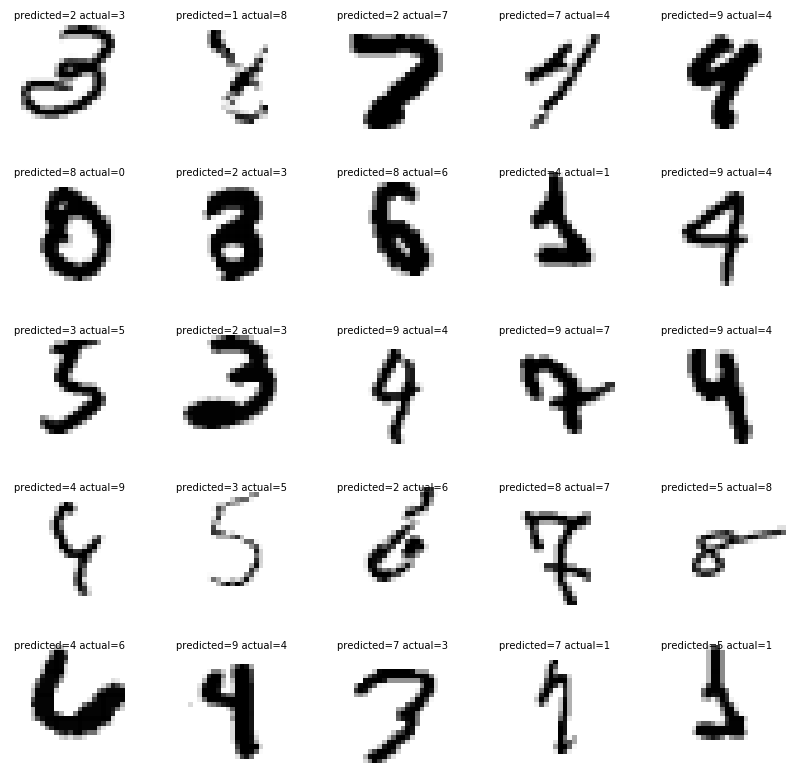

In [0]:
figure=plt.figure(figsize=(14,14))
#displaying 100 images of plot 10,10
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis(False)
  plt.imshow(images_array2[i].cpu().numpy().squeeze(),cmap='gray_r')
  s="predicted="+str(predicted_value2[i])+" actual="+str(actual_value2[i])
  plt.text(1,2,s)

**Model which is Trained using both L1 and L2 regularization**

In [0]:
#for having cooler graphics we can have tqdm installed
from tqdm import tqdm
#we are initialising lists to contain loss and accuracy values to plot some graphs
test_losses3=[]
test_accuracy3=[]
images_array3=[]
predicted_value3=[]
actual_value3=[]
count_images=0
def train3(model,device,scheduler,train_loader,epoch,optimizer):
  #we are calling model.train() so that our model prepares itself in training mode and all other things like batch normalisationa nd dropout behaves accordingly.
  model.train()
  #so tqdm() just acts on a iterator and it will jsut  gives representations in form of progressbar.
  pbar=tqdm(train_loader)
  #variables which contain correct values and processed values which helps in finding accuracy and loss
  correct=0
  processed=0
  for batch_idx,(data,target) in enumerate(pbar):
    #sending data and target samples to device which is gpu
    data,target=data.to(device),target.to(device)
    #we are setting our gradients to zero which is very useful
    optimizer.zero_grad()
    #predicting the output
    y_pred=model(data)#print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
    #calculating the loss
    loss=F.nll_loss(y_pred,target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0 
    for param in model.parameters(): 
        reg_loss += torch.sum(param.abs())

    factor = 0.0005 
    loss += factor * reg_loss
    #appending the losses to train_losses array for plotting graph
    #updating loss and taking a step by optimizer
    loss.backward()
    optimizer.step()
    #updating tqdm and pbar
    #here y_pred will be equal to no of channels in our output
    #actually we need that for backpropagation
    #now we will find highest value which will be our prediction
    #so we will use argmax to fing max value for each image output
    #correct will be no of images correctly processes in batch.we will compare pred value to target.if it is equal it will add one value to correct
    pred=y_pred.argmax(dim=1,keepdim=True)
    processed+=len(data)
    #.sum() will count no of trues in prediction for each batch and .item() will convert our tensor output to scalar output
    correct+=pred.eq(target.view_as(pred)).sum().item()
    #we are appending losses into train_accuracy and we are also appending accuracy at end of each epoch
    pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #train_accuracy.append(100*correct/processed)
    scheduler.step()
  #train_end_epoch.append(train_accuracy[-1])
  
def test3(model,device,test_loader):
  global count_images
  loss=0
  model.eval()
  test_loss=0
  correct=0
  with torch.no_grad():
    for data,target in (test_loader):
      data,target=data.to(device),target.to(device)
      output=model(data)
      test_loss+=F.nll_loss(output,target,reduction='sum').item()
      predicted=output.argmax(dim=1,keepdim=True)
      #print(len(predicted))
      if(count_images<=26):
          for j in range(len(predicted)):
              if(predicted[j]!=target[j]):
                  #print("not matching ","predicted value is",predicted[j].item()," Actual value is ",target[j].item())
                  images_array3.append(data[j])
                  predicted_value3.append(predicted[j].item())
                  actual_value3.append(target[j].item())
                  #figure=plt.figure()
                  #plt.imshow(data[j].cpu().squeeze(),cmap='gray_r')
                  #plt.show()
                  count_images+=1

      correct+=predicted.eq(target.view_as(predicted)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_losses3.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accuracy3.append(100. * correct / len(test_loader.dataset))
    


In [0]:
#importing optimizing step lr and cycle lr from torch.optim.lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
device="cuda" if cuda else "cpu"
model=Net().to(device)
optimizer3=optim.SGD(model.parameters(),lr=0.01,momentum=0.9,weight_decay=0.0005)
#scheduler=StepLR(optimizer,gamma=0.5,step_size=5)
scheduler=OneCycleLR(optimizer3,max_lr=0.1,steps_per_epoch=len(train_loader),epochs=40)
EPOCHS=40
for epoch in range(EPOCHS):
  print('epochs',epoch)
  train3(model,device,scheduler,train_loader,epoch,optimizer3) 
  print(scheduler.get_lr())
  test3(model,device,test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

epochs 0


Loss=0.3972865343093872 Batch_id=468 Accuracy=81.72: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]


[0.005636138390090167]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1343, Accuracy: 9639/10000 (96.39%)

epochs 1


Loss=0.22732001543045044 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:16<00:00, 28.42it/s]

[0.010433014025713727]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0807, Accuracy: 9757/10000 (97.57%)

epochs 2


Loss=0.3762128949165344 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:16<00:00, 30.49it/s]

[0.018063612224373485]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9831/10000 (98.31%)

epochs 3


Loss=0.300788015127182 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]

[0.028007736542228656]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9803/10000 (98.03%)

epochs 4


Loss=0.2603396773338318 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]

[0.03958747183126786]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0572, Accuracy: 9839/10000 (98.39%)

epochs 5


Loss=0.27707865834236145 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]

[0.05201339936426283]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9737/10000 (97.37%)

epochs 6


Loss=0.3032025098800659 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]

[0.06443841342999641]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0837, Accuracy: 9752/10000 (97.52%)

epochs 7


Loss=0.28415098786354065 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]

[0.07601547059053707]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1496, Accuracy: 9541/10000 (95.41%)

epochs 8


Loss=0.28463488817214966 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]

[0.08595533469319193]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1653, Accuracy: 9451/10000 (94.51%)

epochs 9


Loss=0.2575078010559082 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]

[0.09358038101918463]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9823/10000 (98.23%)

epochs 10


Loss=0.28347423672676086 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:15<00:00, 29.33it/s]

[0.09837079160934131]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0855, Accuracy: 9750/10000 (97.50%)

epochs 11


Loss=0.2902500629425049 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]

[0.09999999856920878]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9804/10000 (98.04%)

epochs 12


Loss=0.22548939287662506 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]


[0.09968427106235794]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0698, Accuracy: 9816/10000 (98.16%)

epochs 13


Loss=0.28524160385131836 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:16<00:00, 34.21it/s]

[0.09874373753452848]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9712/10000 (97.12%)

epochs 14


Loss=0.38667309284210205 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:15<00:00, 29.38it/s]

[0.09719022574054306]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0585, Accuracy: 9815/10000 (98.15%)

epochs 15


Loss=0.28606292605400085 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:16<00:00, 28.19it/s]


[0.09504327199257961]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9787/10000 (97.87%)

epochs 16


Loss=0.2670816481113434 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]

[0.09232987547971035]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1379, Accuracy: 9570/10000 (95.70%)

epochs 17


Loss=0.2660461366176605 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]

[0.08908415873743396]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9826/10000 (98.26%)

epochs 18


Loss=0.30260851979255676 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]

[0.08534693853699324]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9779/10000 (97.79%)

epochs 19


Loss=0.2691902816295624 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]


[0.08116521259079444]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9759/10000 (97.59%)

epochs 20


Loss=0.2029421329498291 Batch_id=468 Accuracy=96.77: 100%|██████████| 469/469 [00:16<00:00, 28.12it/s]


[0.0765915685289049]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0822, Accuracy: 9773/10000 (97.73%)

epochs 21


Loss=0.2059294432401657 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:16<00:00, 34.51it/s]

[0.07168352257909298]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9830/10000 (98.30%)

epochs 22


Loss=0.18930405378341675 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:16<00:00, 31.69it/s]

[0.06650279626689218]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0667, Accuracy: 9779/10000 (97.79%)

epochs 23


Loss=0.23909994959831238 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]

[0.0611145402316058]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9769/10000 (97.69%)

epochs 24


Loss=0.24670124053955078 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]

[0.055586514919216574]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9807/10000 (98.07%)

epochs 25


Loss=0.26691514253616333 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]

[0.0499882384554628]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9827/10000 (98.27%)

epochs 26


Loss=0.2170308530330658 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]

[0.04439011241507181]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9820/10000 (98.20%)

epochs 27


Loss=0.3300568461418152 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]

[0.03886253648110994]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1018, Accuracy: 9691/10000 (96.91%)

epochs 28


Loss=0.33701515197753906 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:16<00:00, 37.90it/s]

[0.03347502312812102]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9847/10000 (98.47%)

epochs 29


Loss=0.15361149609088898 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]

[0.028295323462426913]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9858/10000 (98.58%)

epochs 30


Loss=0.2242826670408249 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]


[0.023388575212655503]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9828/10000 (98.28%)

epochs 31


Loss=0.19383853673934937 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]

[0.018816483585009303]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9842/10000 (98.42%)

epochs 32


Loss=0.17260833084583282 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]

[0.014636545284495312]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9864/10000 (98.64%)

epochs 33


Loss=0.1508241593837738 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]

[0.010901325460499198]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9867/10000 (98.67%)

epochs 34


Loss=0.2204306423664093 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 28.76it/s]

[0.007657796669532729]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9836/10000 (98.36%)

epochs 35


Loss=0.11407562345266342 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]

[0.004946748168081546]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9907/10000 (99.07%)

epochs 36


Loss=0.14306829869747162 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:16<00:00, 34.86it/s]

[0.0028022729640383836]



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9925/10000 (99.25%)

epochs 37


Loss=0.14499081671237946 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]


[0.001251339077347576]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9912/10000 (99.12%)

epochs 38


Loss=0.12307122349739075 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]


[0.00031345040150706035]


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

epochs 39


Loss=0.10353925824165344 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 34.34it/s]

[4.0143079121884904e-07]



Test set: Average loss: 0.0233, Accuracy: 9932/10000 (99.32%)



**Misclassified images obtained during training with both L1 and L2 regularization**

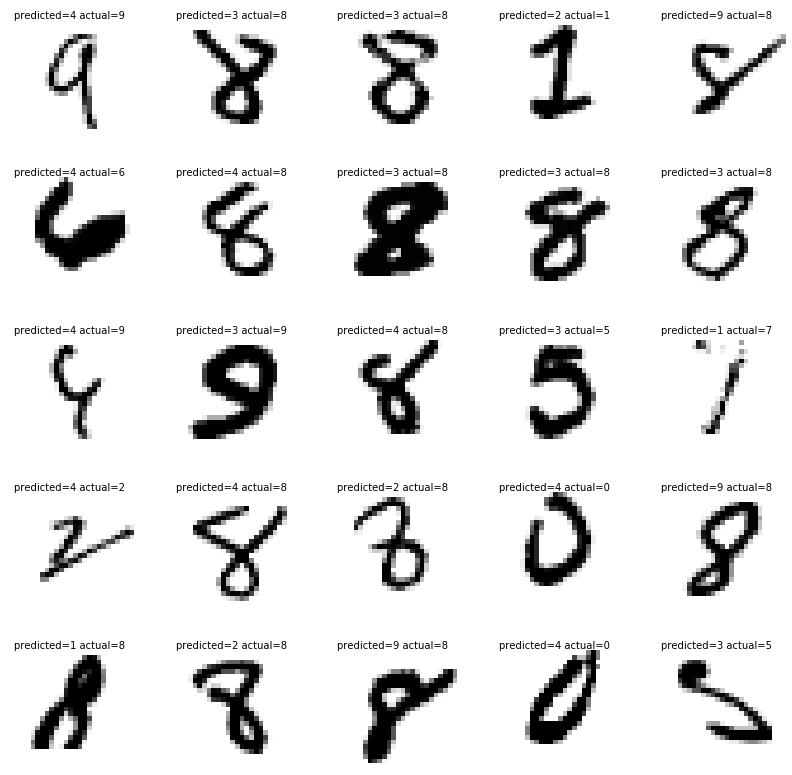

In [0]:
figure=plt.figure(figsize=(14,14))
#displaying 100 images of plot 10,10
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis(False)
  plt.imshow(images_array3[i].cpu().numpy().squeeze(),cmap='gray_r')
  s="predicted="+str(predicted_value3[i])+" actual="+str(actual_value3[i])
  plt.text(1,2,s)

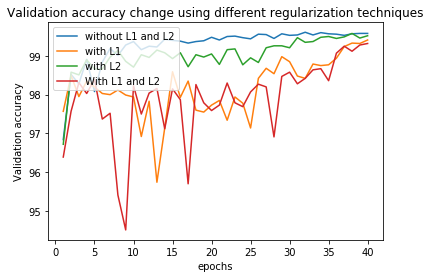

In [0]:
epochs=[i+1 for i in range(40)]
plt.plot(epochs,test_accuracy)
plt.plot(epochs,test_accuracy2)
plt.plot(epochs,test_accuracy1)
plt.plot(epochs,test_accuracy3)
plt.title('Validation accuracy change using different regularization techniques')
plt.ylabel('Validation accuracy')
plt.xlabel('epochs')
plt.legend(['without L1 and L2', 'with L1','with L2','With L1 and L2'], loc='upper left')
plt.show()

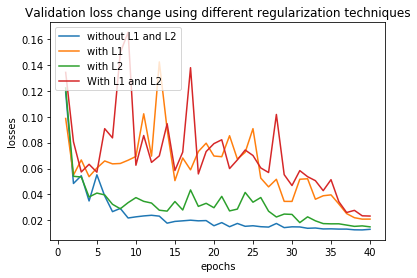

In [0]:
epochs=[i+1 for i in range(40)]
plt.plot(epochs,test_losses)
plt.plot(epochs,test_losses2)
plt.plot(epochs,test_losses1)
plt.plot(epochs,test_losses3)
plt.title('Validation loss change using different regularization techniques')
plt.ylabel('losses')
plt.xlabel('epochs')
plt.legend(['without L1 and L2', 'with L1','with L2','With L1 and L2'], loc='upper left')
plt.show()